In [ ]:
! pip install gpytorch

## Tutorial

In [14]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

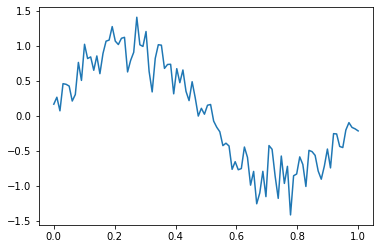

In [4]:
plt.plot(train_x, train_y)

In [5]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.922   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.890   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.856   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.819   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.777   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.732   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.683   lengthscale: 0.438   noise: 0.437
Iter 8/50 - Loss: 0.635   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.588   lengthscale: 0.371   noise: 0.370
Iter 10/50 - Loss: 0.544   lengthscale: 0.341   noise: 0.339
Iter 11/50 - Loss: 0.505   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.468   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.434   lengthscale: 0.272   noise: 0.260
Iter 14/50 - Loss: 0.400   lengthscale: 0.257   noise: 0.237
Iter 15/50 - Loss: 0.367   lengthscale: 0.244   noise: 0.216
Iter 16/50 - Loss: 0.334   lengthscale: 0.235   noise: 0.197
Iter 17/50 - Loss: 0.301   length

In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

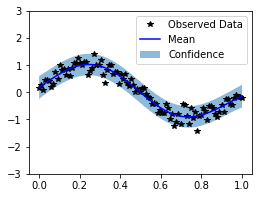

In [8]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

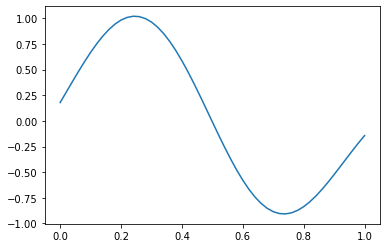

In [13]:
plt.plot(test_x, observed_pred.loc)

## Image

In [30]:
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as F

In [47]:
def _remove_axes(ax):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])


def remove_axes(axes):
    if len(axes.shape) == 2:
        for ax1 in axes:
            for ax in ax1:
                _remove_axes(ax)
    else:
        for ax in axes:
            _remove_axes(ax)

In [94]:
img = Image.open('7.png')
L = T.Compose([
    T.Resize(56),
    T.ToTensor()
])(img).unsqueeze(0)

In [95]:
Hb = nn.Upsample(scale_factor=4, mode='bicubic')(L)

In [63]:
lr2 = T.GaussianBlur(11)(hr)
lr2 = F.interpolate(lr2, scale_factor=(1/4), mode='bilinear', antialias=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

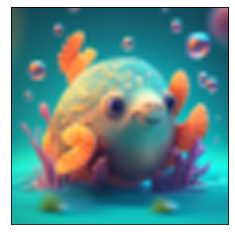

In [97]:
plt.imshow(Hb[0].permute(1,2,0))
plt.xticks([])
plt.yticks([])

In [98]:
patches = nn.Unfold(kernel_size=15, stride=5)(L)

In [99]:
patches = patches.reshape(1, 3, 15, 15, 9, 9)

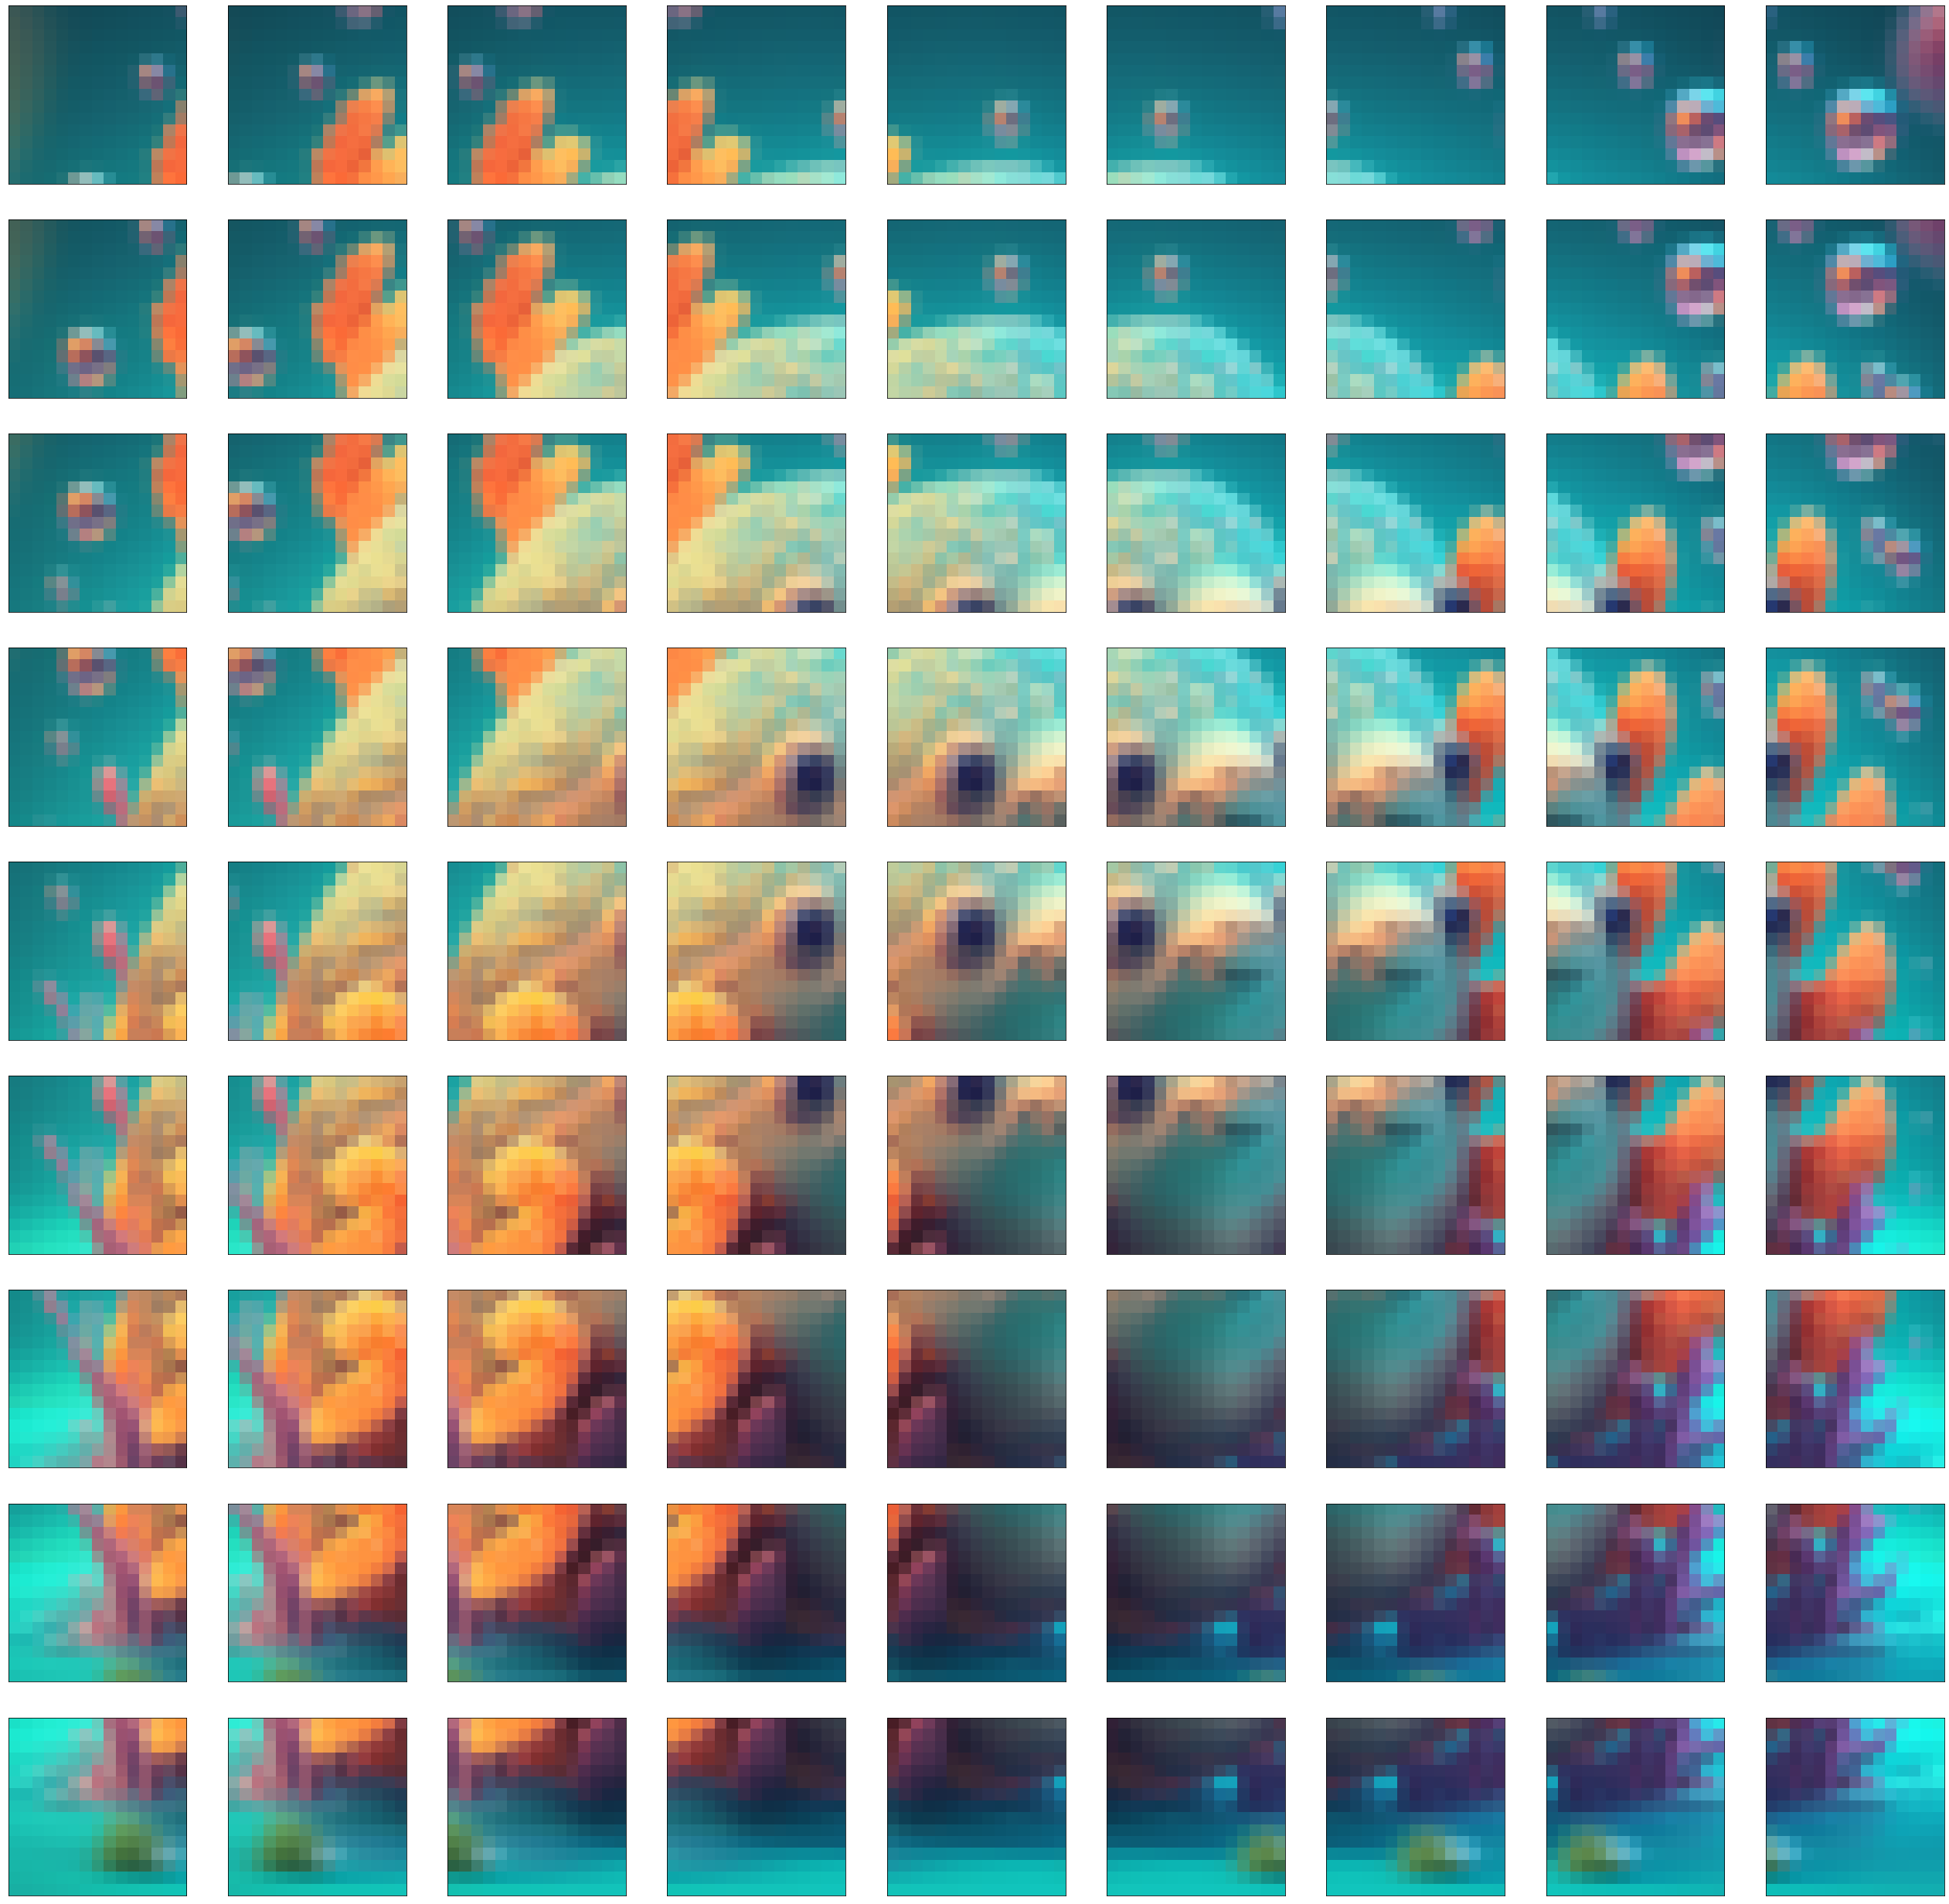

In [100]:
f, ax = plt.subplots(9, 9, figsize=(9*5, 9*5))
for i in range(9):
    for j in range(9):
        ax[i][j].imshow(patches[0, :, :, :, i, j].permute(1, 2, 0))
remove_axes(ax)
plt.show()

In [89]:
patch = patches[:, :, :, :, 3, 3]

([], [])

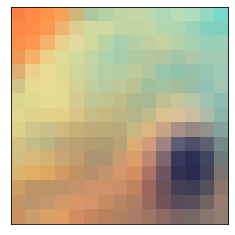

In [104]:
plt.imshow(patch[0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])

In [128]:
training = nn.Unfold(kernel_size=3, stride=3)(patch)
training = training.reshape(1, 3, 3, 3, 5, 5)

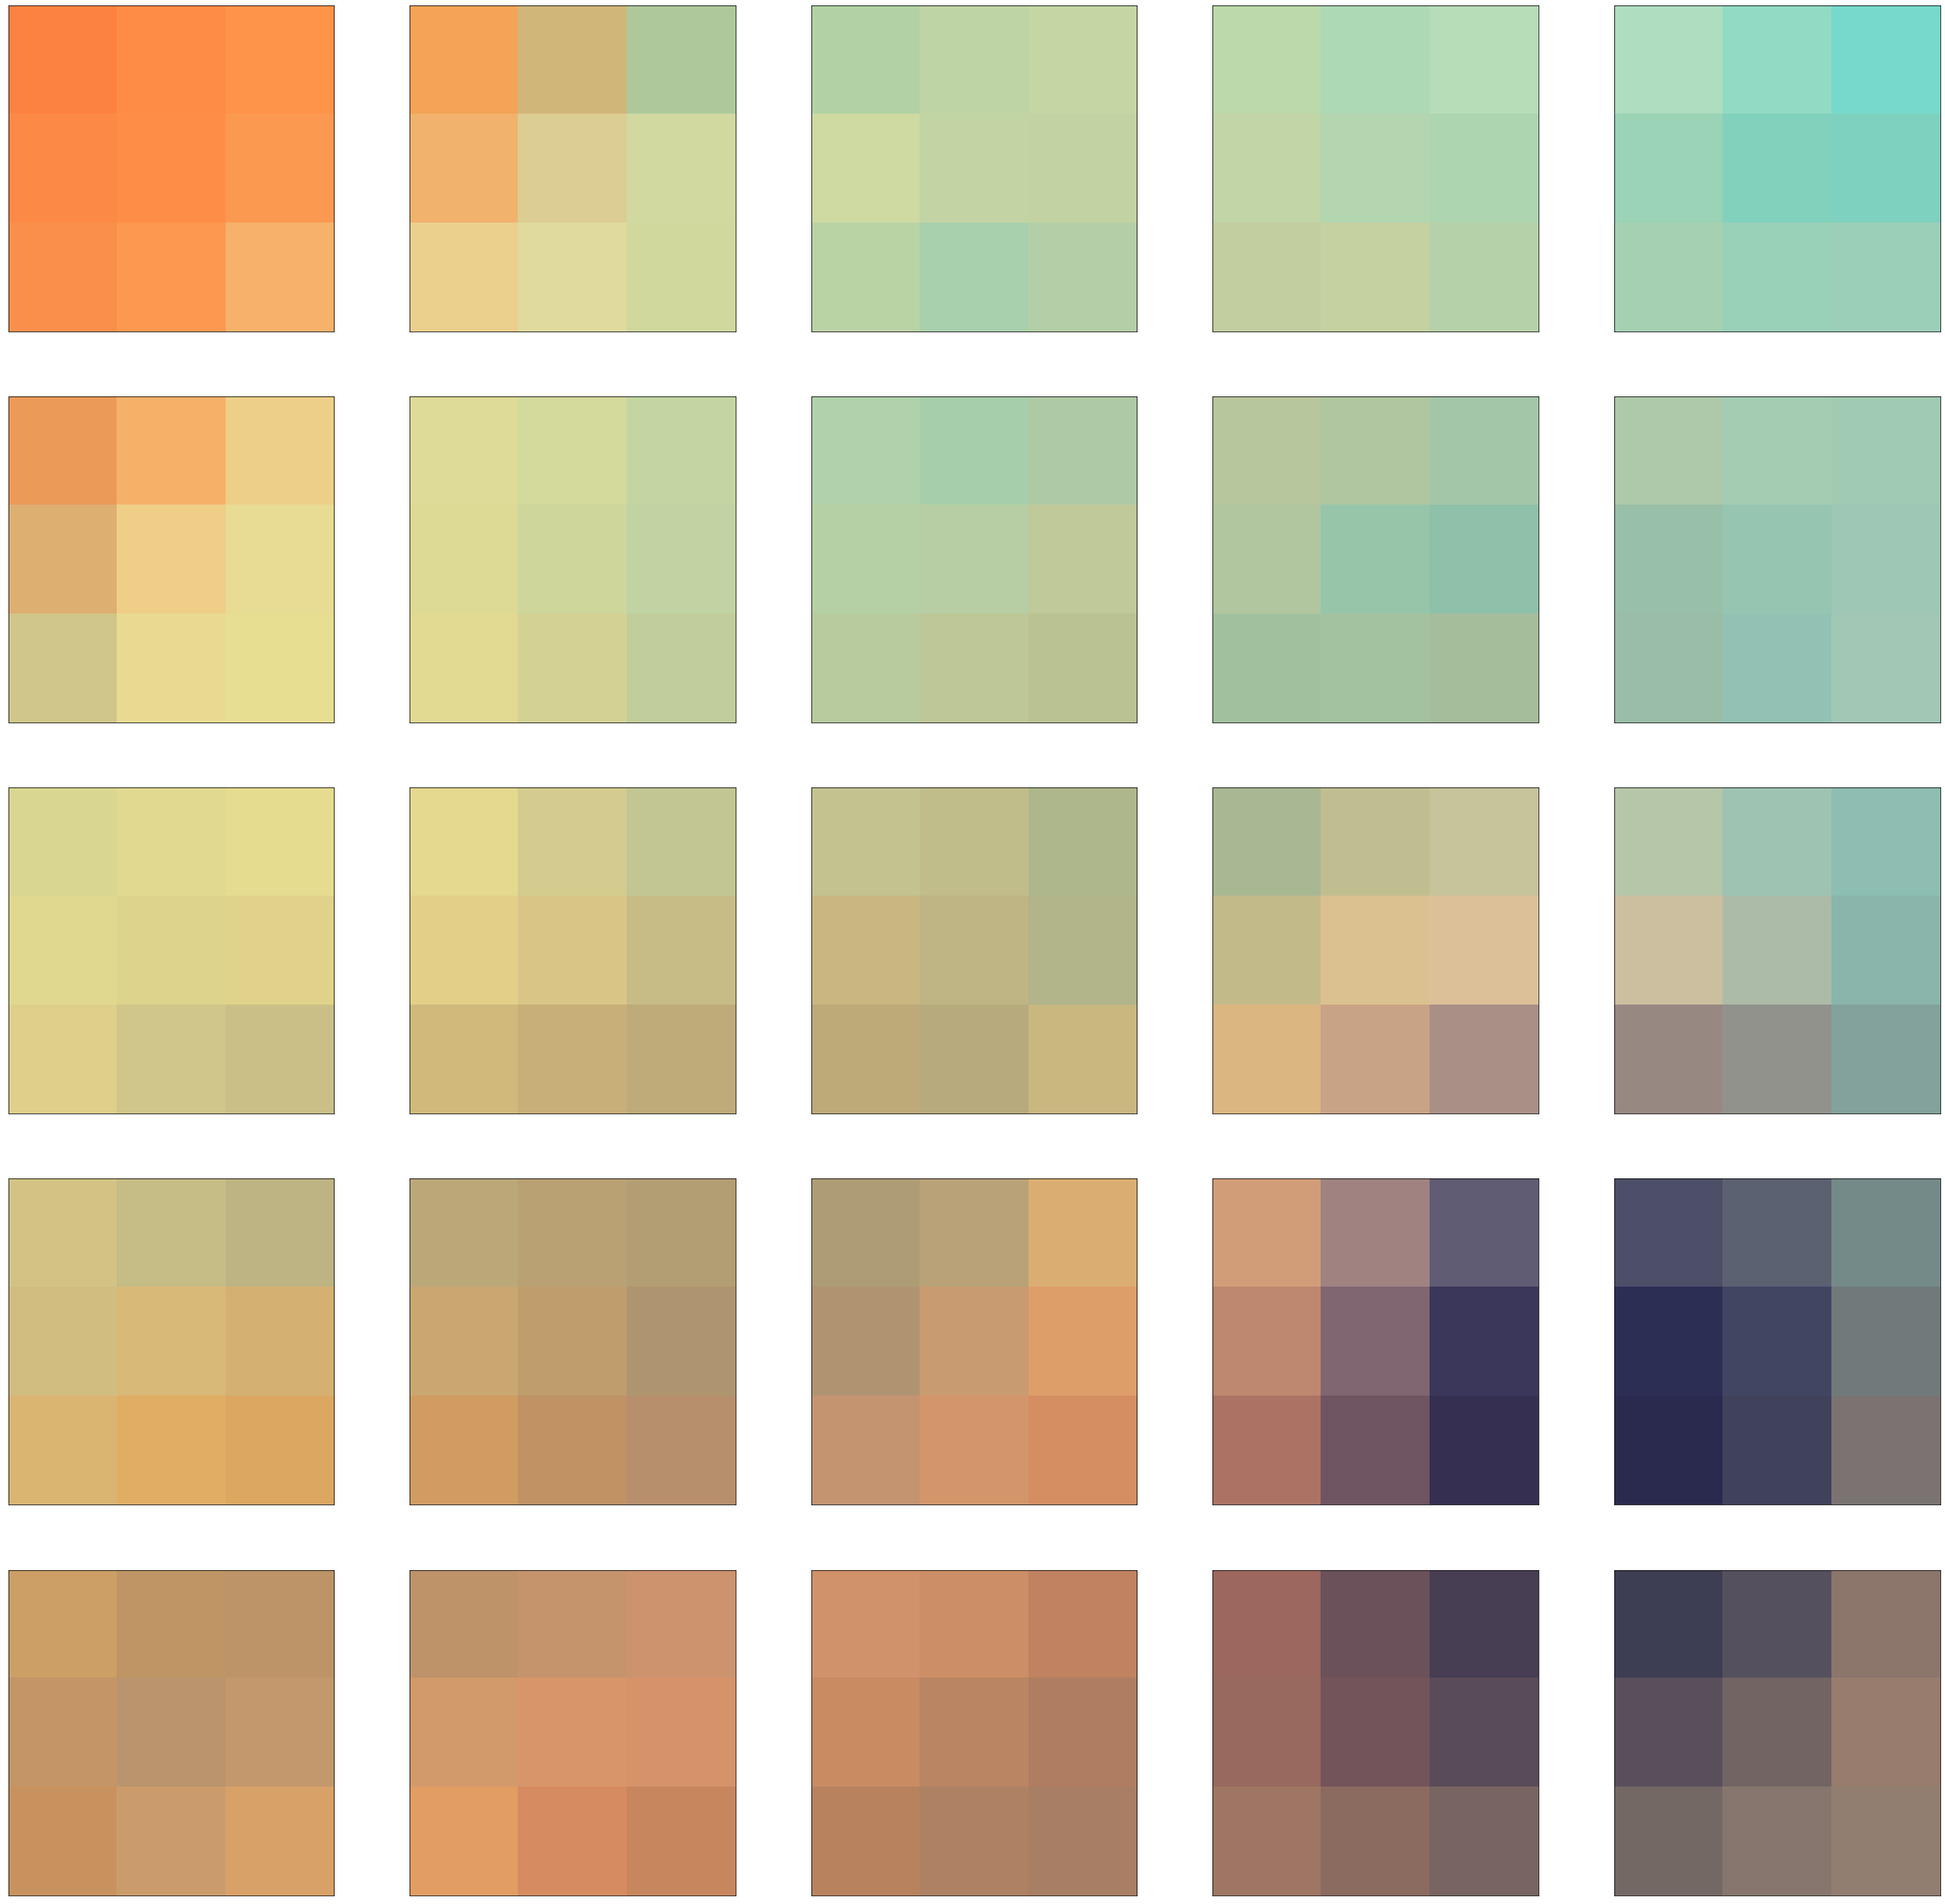

In [131]:
f, ax = plt.subplots(5, 5, figsize=(9*5, 9*5))
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(training[0, :, :, :, i, j].permute(1, 2, 0))
remove_axes(ax)
plt.show()

([], [])

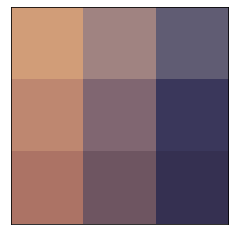

In [132]:
training_x = training[0, :, :, :, 3, 3]
# training_x[:, 1, 1] = 0
plt.imshow(training_x.permute(1, 2, 0))
plt.xticks([])
plt.yticks([])

torch.Size([1, 9, 3])


([], [])

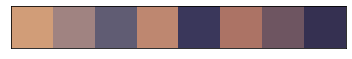

In [121]:
Xnl = training_x.reshape(3, 1, 9).permute(1, 2, 0)
print(Xnl.shape)
Xnl = torch.cat([Xnl[:, :4, :], Xnl[:, 5:, :]], dim=1)
plt.imshow(Xnl)
plt.xticks([])
plt.yticks([])

([], [])

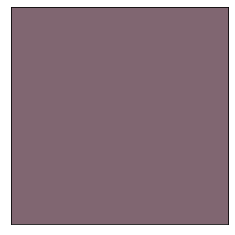

In [129]:
y = training[0, :, :, :, 3, 3]
y = y[:, 1, 1]
plt.imshow(y.unsqueeze(0).unsqueeze(0))
plt.xticks([])
plt.yticks([])